# TP Advanced Machine Learning : Part 2

We used **onyxia** virtual machines to speed up the calculations.

In [ ]:
# !pip install torch
# !pip install torchvision
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# Question 1

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
import torch.nn.functional as F
from tqdm import tqdm
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model, clip_preprocess = clip.load("ViT-B/32", device=device)

model = model.to(device)

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=clip_preprocess)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=clip_preprocess)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We create a first net that uses the clip model as a backbone. To do so, we use the ```encode_image``` method after loading the clip model with ```import clip```. As we found out the ```encode_image``` gives an tensor of dimension 512. We than apply to linear transformations to get the output size (=10). We first apply the ```gelu``` activation function as suggested.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = model.encode_image(x).float()
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

We then create an instance of the net : 

In [7]:
net = Net()
net = net.to(device)

We then to use a **stochastic gradient descent** and an **entropy loss function**

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

We define arrays to keep track of the results.

In [9]:
loss_in_time = []

We apply the usual loop for training the model :

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(trainloader, 0)):
        # load inputs to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients this is important to do it at each batch since the gradient are accumulated
        optimizer.zero_grad()

        # forward - Graph is created
        outputs = net(inputs)

        # We compute the loss
        loss = criterion(outputs, labels)

        loss_in_time.append(loss.item())

        # backward - gradients of the the parameters of the model are computed
        loss.backward()

        # Gradient step on the parameters referenced in the optimizer
        optimizer.step()

        # print statistics
        running_loss += loss.item() * len(labels)

    # print every epoch
    print(f'Epoch {epoch:03}: train loss {running_loss / len(trainset):0.5}')
    running_loss = 0.0


 11%|█         | 86/782 [00:15<02:03,  5.64it/s]


KeyboardInterrupt: 

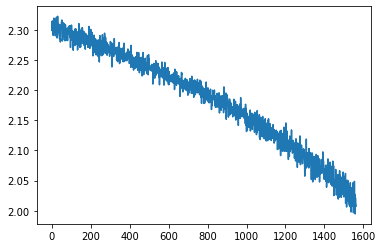

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_in_time[i for i in range(len)])

Then, we **test** the model : 

In [15]:
test_loss, correct = 0, 0
size = len(testloader.dataset)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(testloader, 0)):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

test_loss /= 64
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



100%|██████████| 157/157 [00:25<00:00,  6.15it/s]

Test Error: 
 Accuracy: 78.1%, Avg loss: 4.950397 



# Question 2 :

We create a function to plot the image we are wondering about : 

In [75]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

We downloaded the hymenoptera file from the this link ```https://download.pytorch.org/tutorial/hymenoptera_data.zip```

As we could not download file bigger than 15 Mb, we use the request librairy to do so : 

In [76]:
# import requests

# url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
# r = requests.get(url, allow_redirects=True)

# open('hymenoptera_data.zip', 'wb').write(r.content)

47286322

We then unzip the result : 

In [12]:
# from zipfile import ZipFile

# with ZipFile('hymenoptera_data.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

We load the **train** and **val** datasets.

In [77]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(os.getcwd(), 'hymenoptera_data', x), clip_preprocess) for x in ['train', 'val']}

We get the classes ```ants``` and ```bees``` from the datasets.

In [78]:
classes = image_datasets['train'].classes

We load the correspondind dataloaders.

In [79]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train', 'val']}

We wonder about the training part : 

In [80]:
train_inputs = dataloaders['train']

We gather one image and its class : 

In [82]:
one_input, classe = next(iter(dataloaders['train']))

We transform the input : 

In [83]:
image_input = one_input.to(device)

```clip.tokenize``` tranform the test into a longTensor so that it can be used by the clip model. ```torch.cat``` concatenate the result.

In [84]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

We use the clip model to get the enconding of both image and text

In [85]:
with torch.no_grad(): # We do not need to update the weigths
    image_features = model.encode_image(image_input) 
    text_features = model.encode_text(text_inputs)

We divide by the norm : 

In [86]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True) # We divide by the norm 
text_features /= text_features.norm(dim=-1, keepdim=True) # We divide by the norm 

We get similarity between the image and the text using the ```softmax``` method.

In [87]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

We print the similarity for each class of the dataset : 


Top predictions:

            ants : 99.85%
            bees : 0.13%


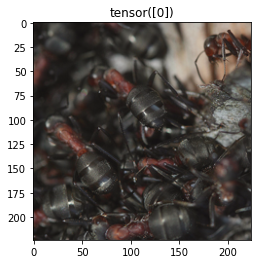

In [89]:
values, indices = similarity[0].topk(2)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{classes[index]:>16s} : {100*value.item():.2f}%")
out = torchvision.utils.make_grid(one_input)
imshow(out, title=classe)